# Defocus Model
Stokeseth Approximation

In [208]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, fftshift
from scipy.special import jv
import pickle

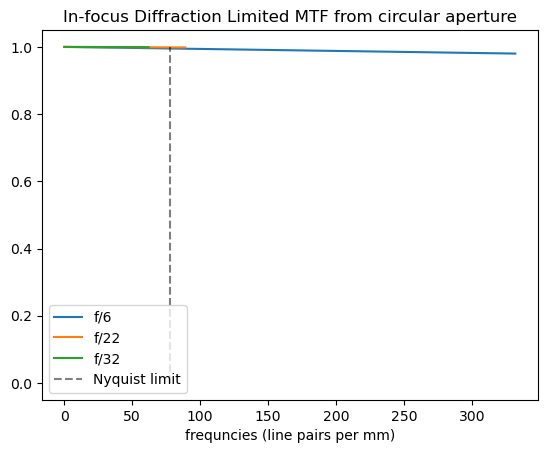

In [36]:
def MTF(v, NA):
    # N = 6 # f-number
    N = 1/(2*NA)
    phi = np.arccos(lamb*1000*v * N)
    return 2/np.pi * (phi - np.cos(phi)*np.sin(phi))
e = 6.45/1000

v = np.arange(0, 333)
plt.plot(v, MTF(v, 6), label='f/6')
v = np.arange(0, 90)
plt.plot(v, MTF(v, 22), label='f/22')
v = np.arange(0, 63)
plt.plot(v, MTF(v, 32), label='f/32')
plt.xlabel('frequncies (line pairs per mm)')

plt.title('In-focus Diffraction Limited MTF from circular aperture')
plt.vlines(1/(2*e), 0, 1, alpha = 0.5, ls = '--', color='black', label='Nyquist limit')
plt.legend()

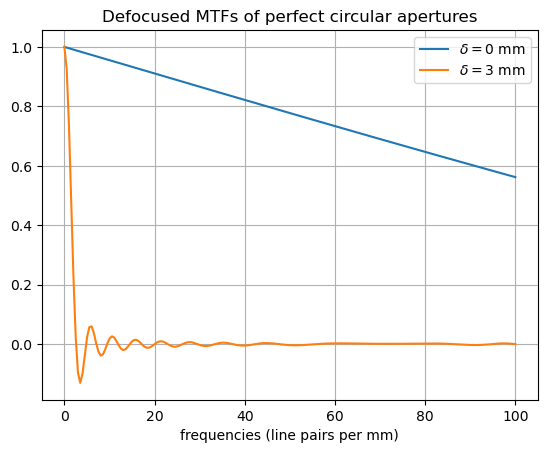

In [60]:
def stokeseth(s, w, lamb):
    # w: defocus
    # lamb: wavelength
    a = 4*np.pi*w*s/lamb
    return 2*(1-0.69*s + 0.0076*s**2 + 0.043*s**3)* jv(1, (a - 0.5*a*s))/ (a - 0.5*a*s)

def defocus_factor(v, NA, delta):
    # delta is defocus
    N = 1/NA
    v0= 1/(lamb*1000* N) # cutoff frequency
    x = 2*np.pi * delta* NA* v*(v0-v)/v0 
    return 2*jv(1, x)/x

NA = 0.08
v = np.linspace(0.001,100,200)

defocus = 3 
defocused_MTF = MTF(v, NA)*defocus_factor(v, NA, defocus)
defocused_MTF = np.nan_to_num(defocused_MTF,  nan=0.0, posinf=None, neginf=None)

plt.plot(v, MTF(v, NA), label='$\delta = 0$ mm')
plt.plot(v, defocused_MTF, label=f'$\delta = {defocus}$ mm')
plt.title('Defocused MTFs of perfect circular apertures')
plt.xlabel('frequencies (line pairs per mm)')
plt.grid()
plt.legend()

/var/folders/55/y8nplzr92z3002w35fdrm2wc0000gn/T/ipykernel_22143/1332301957.py:4: RuntimeWarning: invalid value encountered in arccos
  phi = np.arccos(lamb*1000*v * N)


Text(0.5, 0, 'Distance ($\\mu$m)')

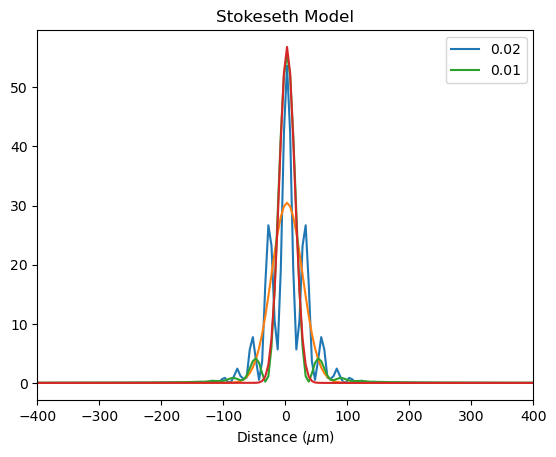

In [146]:
def calculate_defocused_PSF(NA, defocus):
    # NA (np.float): Numerical Aperture
    # defocus (np.float): in mm
    
    defocused_MTF = MTF(v, NA)*defocus_factor(v, NA, defocus)
    defocused_MTF = np.nan_to_num(defocused_MTF,  nan=0.0, posinf=None, neginf=None)
    full_MTF = np.concatenate((defocused_MTF, defocused_MTF[::-1]))
    full_PSF = fftshift(np.abs(fft(full_MTF)))
    return full_PSF

def gaussian(x, mu, sigma, A):
    return A*np.exp(-((x-mu)**2/(sigma)**2 / 2))
from scipy.optimize import curve_fit

max_freq = 100 # lp/mm
N_points = 200
v = np.linspace(0.001,max_freq, N_points)

# full_MTF = np.concatenate((defocused_MTF, defocused_MTF[::-1]))
distance_range = np.linspace(-N_points/(max_freq*2), N_points/(max_freq*2), 2*N_points) * 1000 # in um
# plt.plot(distance_range, calculate_defocused_PSF(0.08, 3), label='0.08')
# plt.plot(distance_range, calculate_defocused_PSF(0.01, 3), label='0.01')

# Fit
for NA in [0.02, 0.01]:
    array = calculate_defocused_PSF(NA, 3)
    plt.plot(distance_range, array, label=f'{NA}')
    p0 = [0, 100, 20]
    popt, pcov = curve_fit(gaussian, distance_range, array, p0=p0)
    plt.plot(distance_range, gaussian(distance_range, *popt))
plt.legend()
plt.xlim(-400, 400)
plt.title('Stokeseth Model')
plt.xlabel('Distance ($\mu$m)')

/var/folders/55/y8nplzr92z3002w35fdrm2wc0000gn/T/ipykernel_22143/1332301957.py:4: RuntimeWarning: invalid value encountered in arccos
  phi = np.arccos(lamb*1000*v * N)


Text(0.5, 0, 'NA')

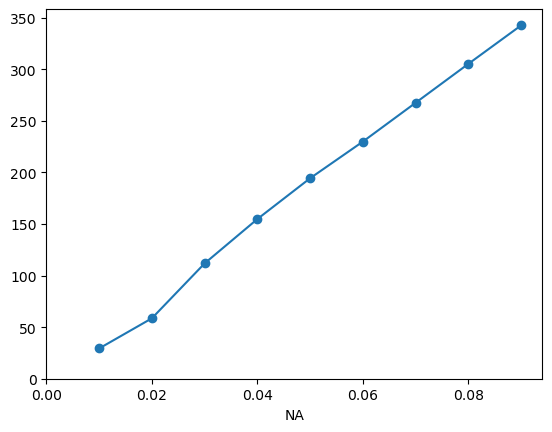

In [214]:
NAs = np.arange(0.01, 0.1, 0.01)

defocus = 3.354 #(mm)
defocused_PSF_arrays = np.zeros((len(NAs), 2*N_points))
defocused_PSF_width = []
defocused_PSF_width_errors = []

for idx, NA in enumerate(NAs):
    defocused_PSF_arrays[idx] = calculate_defocused_PSF(NA, 3)

for idx, NA in enumerate(NAs):
    array = defocused_PSF_arrays[idx]
    popt, pcov = curve_fit(gaussian, distance_range, array, p0=p0, bounds=((-np.inf, -np.inf, np.max(array)/4),  (np.inf, np.inf, np.inf) ))
    width = popt[1]

    defocused_PSF_width.append(width)
    defocused_PSF_width_errors.append(np.sqrt(pcov[1,1]))

# for i in range(0,50, 10):
#     plt.plot(distance_range, defocused_PSF_arrays[i, :])
# plt.xlim(-200, 200)
# plt.show()
FWHM_widths = 2.355* np.array(defocused_PSF_width)
plt.plot(NAs,FWHM_widths , marker='o', )
# plt.errorbar(NAs, 2.355* np.array(defocused_PSF_width), yerr =2.355* np.array(defocused_PSF_width_errors),  marker='o', )
plt.ylim(0,)
plt.xlim(0,)
plt.xlabel('NA')

In [183]:
def get_fwhm(array, pixel_length, broadening_factor=2):
    N = len(array)
    difference = np.abs(array - np.max(array)/broadening_factor)
    idx_neg = np.argmin(difference[:N//2])
    idx_pos = np.argmin(difference[N//2::]) + N//2
    width = (idx_pos - idx_neg) * pixel_length
    return width


pixel_length = distance_range[1] - distance_range[0]
defocused_PSF_width = []
for idx, NA in enumerate(NAs):
    array = defocused_PSF_arrays[idx]
    width = get_fwhm(array, pixel_length)
    defocused_PSF_width.append(width)

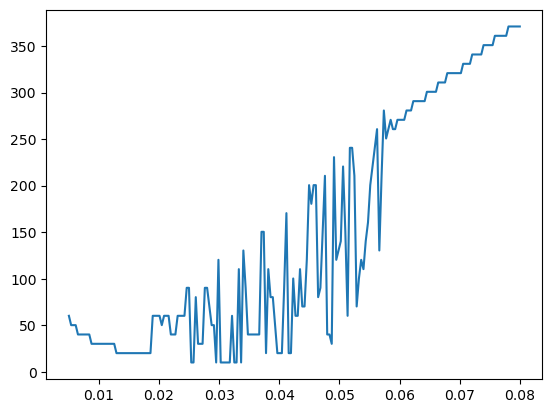

In [185]:
plt.plot(NAs, defocused_PSF_width)
# plt.ylim(0,)
# plt.xlim(0,)

/var/folders/55/y8nplzr92z3002w35fdrm2wc0000gn/T/ipykernel_22143/2288115306.py:7: RuntimeWarning: invalid value encountered in true_divide
  return 2*(1-0.69*s + 0.0076*s**2 + 0.043*s**3)* jv(1, (a - 0.5*a*s))/ (a - 0.5*a*s)


Text(0.5, 1.0, 'Stokeseth Approximation')

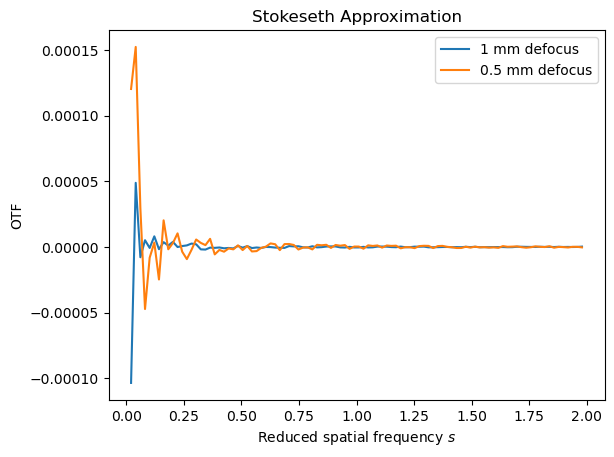

In [217]:
lamb = 562e-9

s = np.linspace(0,2,100)
vals = stokeseth(s, 1e-3, 500e-9)
plt.plot(s, vals, label='1 mm defocus')
plt.plot(s, stokeseth(s, .5e-3, lamb), label='0.5 mm defocus')

plt.legend()
plt.ylabel('OTF')
plt.xlabel('Reduced spatial frequency $s$')
plt.title('Stokeseth Approximation')

Dump to file

In [215]:
stokeseth_data = {'NAs': NAs, 'FWHM_widths':FWHM_widths}

with open('../report_plots/3_characterisation/stokeseth_data.pkl', 'wb') as f:
    pickle.dump(stokeseth_data, f)